In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import catboost
import seaborn as sns

from pystacknet.pystacknet import StackNetRegressor

VALIDATION = False

/home/jeeva/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
if(VALIDATION):
    #train = train.sample(frac=1).reset_index(drop=True)
    test = train[3000:].drop(['SalesInMillions'], axis=1) 
    yvalid = train[3000:].SalesInMillions
    train = train[:3000]

In [4]:
traintest = pd.concat([train,test],axis= 0)

traintest.shape

(5009, 9)

In [5]:
traintest.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,1.779257
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,0.215050
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,0.534402
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,1.383964
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,0.082671


## BINNING

In [6]:
traintest.CRITICS_POINTS = preprocessing.scale(traintest.CRITICS_POINTS)
traintest.USER_POINTS = preprocessing.scale(traintest.USER_POINTS)

traintest.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,-0.307499,-0.222066,1.779257
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,2.938074,2.711329,0.215050
2,495,pc,2019,shooter,Activision,M,0.233865,-0.874675,0.534402
3,2641,ps2,2002,sports,Electronic Arts,E,0.114682,-0.171095,1.383964
4,811,ps3,2013,action,Activision,M,-0.487228,-0.817230,0.082671


In [7]:
traintest['BIN_CRITICS'] = traintest['RATING']
traintest['BIN_USERS'] = traintest['RATING']

prev = 0
for i in range(-2,10):
    traintest.loc[(traintest.CRITICS_POINTS >= i) & (traintest.CRITICS_POINTS < i+1),'BIN_CRITICS'] = prev
    prev += 1
    
prev = 0
for i in range(-1,10):
    traintest.loc[(traintest.USER_POINTS >= i) & (traintest.USER_POINTS < i+1),'BIN_USERS'] = prev
    prev += 1
    
traintest.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions,BIN_CRITICS,BIN_USERS
0,2860,ds,2008,role-playing,Nintendo,E,-0.307499,-0.222066,1.779257,1,0
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,2.938074,2.711329,0.215050,4,3
2,495,pc,2019,shooter,Activision,M,0.233865,-0.874675,0.534402,2,0
3,2641,ps2,2002,sports,Electronic Arts,E,0.114682,-0.171095,1.383964,2,0
4,811,ps3,2013,action,Activision,M,-0.487228,-0.817230,0.082671,1,0


In [8]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5009 entries, 0 to 1502
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               5009 non-null   int64  
 1   CONSOLE          5009 non-null   object 
 2   YEAR             5009 non-null   int64  
 3   CATEGORY         5009 non-null   object 
 4   PUBLISHER        5009 non-null   object 
 5   RATING           5009 non-null   object 
 6   CRITICS_POINTS   5009 non-null   float64
 7   USER_POINTS      5009 non-null   float64
 8   SalesInMillions  3506 non-null   float64
 9   BIN_CRITICS      5009 non-null   object 
 10  BIN_USERS        5009 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 469.6+ KB


## COMBINATION

In [9]:
#cat_feat = ['CONSOLE','YEAR','PUBLISHER','CATEGORY','RATING']
cat_feat = ['CONSOLE','YEAR','PUBLISHER','CATEGORY','RATING','BIN_USERS','BIN_CRITICS']

comb_feat = []

for i,col1 in enumerate(cat_feat):
    for j,col2 in enumerate(cat_feat):
        if(j==i):
            break
        traintest[f'COMB_{col1}_{col2}'] = np.char.add(list(map(str,traintest[col1])),['|']*traintest.shape[0])
        traintest[f'COMB_{col1}_{col2}'] = np.char.add(list(map(str,traintest[f'COMB_{col1}_{col2}'])),list(map(str,traintest[col2])))    
        
        if(traintest[f'COMB_{col1}_{col2}'].nunique() > 500):
            traintest = traintest.drop([f'COMB_{col1}_{col2}'], axis= 1)
            break
            
        comb_feat.append(f'COMB_{col1}_{col2}')
        print(f"Unique Values of COMB_{col1}_{col2} is {traintest[f'COMB_{col1}_{col2}'].nunique()}")
            
traintest.head()

Unique Values of COMB_YEAR_CONSOLE is 175
Unique Values of COMB_CATEGORY_CONSOLE is 192
Unique Values of COMB_CATEGORY_YEAR is 251
Unique Values of COMB_RATING_CONSOLE is 68
Unique Values of COMB_RATING_YEAR is 92
Unique Values of COMB_RATING_PUBLISHER is 439
Unique Values of COMB_RATING_CATEGORY is 50
Unique Values of COMB_BIN_USERS_CONSOLE is 80
Unique Values of COMB_BIN_USERS_YEAR is 108
Unique Values of COMB_BIN_USERS_PUBLISHER is 482
Unique Values of COMB_BIN_USERS_CATEGORY is 65
Unique Values of COMB_BIN_USERS_RATING is 27
Unique Values of COMB_BIN_CRITICS_CONSOLE is 107
Unique Values of COMB_BIN_CRITICS_YEAR is 137
Unique Values of COMB_BIN_CRITICS_PUBLISHER is 492
Unique Values of COMB_BIN_CRITICS_CATEGORY is 81
Unique Values of COMB_BIN_CRITICS_RATING is 35
Unique Values of COMB_BIN_CRITICS_BIN_USERS is 39


,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions,BIN_CRITICS,...,COMB_BIN_USERS_YEAR,COMB_BIN_USERS_PUBLISHER,COMB_BIN_USERS_CATEGORY,COMB_BIN_USERS_RATING,COMB_BIN_CRITICS_CONSOLE,COMB_BIN_CRITICS_YEAR,COMB_BIN_CRITICS_PUBLISHER,COMB_BIN_CRITICS_CATEGORY,COMB_BIN_CRITICS_RATING,COMB_BIN_CRITICS_BIN_USERS
0,2860,ds,2008,role-playing,Nintendo,E,-0.307499,-0.222066,1.779257,1,...,0|2008,0|Nintendo,0|role-playing,0|E,1|ds,1|2008,1|Nintendo,1|role-playing,1|E,1|0
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,2.938074,2.711329,0.215050,4,...,3|2012,3|Konami Digital Entertainment,3|simulation,3|E10+,4|wii,4|2012,4|Konami Digital Entertainment,4|simulation,4|E10+,4|3
2,495,pc,2019,shooter,Activision,M,0.233865,-0.874675,0.534402,2,...,0|2019,0|Activision,0|shooter,0|M,2|pc,2|2019,2|Activision,2|shooter,2|M,2|0
3,2641,ps2,2002,sports,Electronic Arts,E,0.114682,-0.171095,1.383964,2,...,0|2002,0|Electronic Arts,0|sports,0|E,2|ps2,2|2002,2|Electronic Arts,2|sports,2|E,2|0
4,811,ps3,2013,action,Activision,M,-0.487228,-0.817230,0.082671,1,...,0|2013,0|Activision,0|action,0|M,1|ps3,1|2013,1|Activision,1|action,1|M,1|0


In [10]:
for col in traintest.columns:
    if(traintest[col].dtype == object):
        traintest[col] = traintest[col].factorize()[0]
    
traintest.YEAR = traintest.YEAR - 1988
traintest.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions,BIN_CRITICS,...,COMB_BIN_USERS_YEAR,COMB_BIN_USERS_PUBLISHER,COMB_BIN_USERS_CATEGORY,COMB_BIN_USERS_RATING,COMB_BIN_CRITICS_CONSOLE,COMB_BIN_CRITICS_YEAR,COMB_BIN_CRITICS_PUBLISHER,COMB_BIN_CRITICS_CATEGORY,COMB_BIN_CRITICS_RATING,COMB_BIN_CRITICS_BIN_USERS
0,2860,0,20,0,0,0,-0.307499,-0.222066,1.779257,0,...,0,0,0,0,0,0,0,0,0,0
1,731,1,24,1,1,1,2.938074,2.711329,0.215050,1,...,1,1,1,1,1,1,1,1,1,1
2,495,2,31,2,2,2,0.233865,-0.874675,0.534402,2,...,2,2,2,2,2,2,2,2,2,2
3,2641,3,14,3,3,0,0.114682,-0.171095,1.383964,2,...,3,3,3,0,3,3,3,3,3,2
4,811,4,25,4,2,2,-0.487228,-0.817230,0.082671,0,...,4,2,4,2,4,4,4,4,4,0


## MEAN ENCODING

In [11]:
train = traintest[:train.shape[0]]
test = traintest[train.shape[0]:]

In [12]:
columns_to_encode = ['RATING','PUBLISHER','CATEGORY','YEAR','CONSOLE'] + comb_feat
mean_feat = []

for col in columns_to_encode:
    encode_map = train.groupby(col)['SalesInMillions'].mean()
    train.loc[:, f'MEAN_{col}'] = train[col].map(encode_map)
    test.loc[:, f'MEAN_{col}'] = test[col].map(encode_map)
    
    mean_feat.append(f'MEAN_{col}')
    
train.head()

/home/jeeva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jeeva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions,BIN_CRITICS,...,MEAN_COMB_BIN_USERS_YEAR,MEAN_COMB_BIN_USERS_PUBLISHER,MEAN_COMB_BIN_USERS_CATEGORY,MEAN_COMB_BIN_USERS_RATING,MEAN_COMB_BIN_CRITICS_CONSOLE,MEAN_COMB_BIN_CRITICS_YEAR,MEAN_COMB_BIN_CRITICS_PUBLISHER,MEAN_COMB_BIN_CRITICS_CATEGORY,MEAN_COMB_BIN_CRITICS_RATING,MEAN_COMB_BIN_CRITICS_BIN_USERS
0,2860,0,20,0,0,0,-0.307499,-0.222066,1.779257,0,...,2.710504,4.524301,2.240934,3.010081,2.503541,2.457662,4.503205,2.177107,2.872047,2.518022
1,731,1,24,1,1,1,2.938074,2.711329,0.215050,1,...,1.207616,1.226222,1.402500,1.849865,1.811101,0.892670,1.784481,1.731401,1.994373,1.720359
2,495,2,31,2,2,2,0.233865,-0.874675,0.534402,2,...,1.489968,2.730374,2.662401,2.558257,1.653424,1.739701,1.960251,2.263079,2.077481,2.002590
3,2641,3,14,3,3,0,0.114682,-0.171095,1.383964,2,...,2.838201,2.422768,2.844294,3.010081,2.027579,2.124294,2.197859,1.942350,1.916233,2.002590
4,811,4,25,4,2,2,-0.487228,-0.817230,0.082671,0,...,2.169152,2.730374,2.200937,2.558257,2.272365,2.116314,2.651302,2.178477,2.498938,2.518022


In [13]:
print(test.isnull().sum())

test.fillna(-1,inplace=True)

ID                                    0
CONSOLE                               0
YEAR                                  0
CATEGORY                              0
PUBLISHER                             0
RATING                                0
CRITICS_POINTS                        0
USER_POINTS                           0
SalesInMillions                    1503
BIN_CRITICS                           0
BIN_USERS                             0
COMB_YEAR_CONSOLE                     0
COMB_CATEGORY_CONSOLE                 0
COMB_CATEGORY_YEAR                    0
COMB_RATING_CONSOLE                   0
COMB_RATING_YEAR                      0
COMB_RATING_PUBLISHER                 0
COMB_RATING_CATEGORY                  0
COMB_BIN_USERS_CONSOLE                0
COMB_BIN_USERS_YEAR                   0
COMB_BIN_USERS_PUBLISHER              0
COMB_BIN_USERS_CATEGORY               0
COMB_BIN_USERS_RATING                 0
COMB_BIN_CRITICS_CONSOLE              0
COMB_BIN_CRITICS_YEAR                 0


/home/jeeva/.local/lib/python3.6/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Tree Models

In [14]:
useless_tree_feat = ['BIN_USERS','BIN_CRITICS'] + mean_feat

X = train.drop(['SalesInMillions'] + useless_tree_feat, axis=1) 
y = train.SalesInMillions
Xtest = test.drop(['SalesInMillions'] + useless_tree_feat, axis=1)

scaledX = preprocessing.scale(X)
scaledXtest = preprocessing.scale(Xtest)

In [15]:
model = RandomForestRegressor(n_estimators=500, n_jobs=-1)

model.fit(scaledX,y)
predictions1 = model.predict(scaledXtest)

if(VALIDATION):
    print(mean_squared_error(yvalid,predictions1,squared=False))

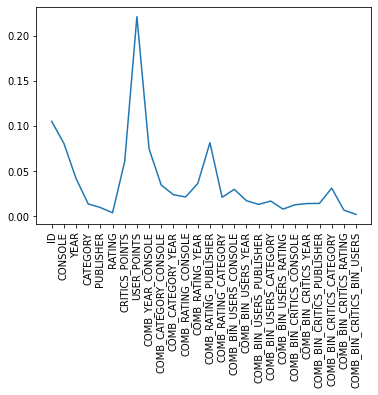

In [16]:
plt.plot(model.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90);

In [17]:
model = xgb.XGBRegressor(n_estimators=100,learning_rate=0.05,n_jobs=-1)

model.fit(scaledX,y)
predictions2 = model.predict(scaledXtest)

if(VALIDATION):
    print(mean_squared_error(yvalid,predictions2,squared=False))

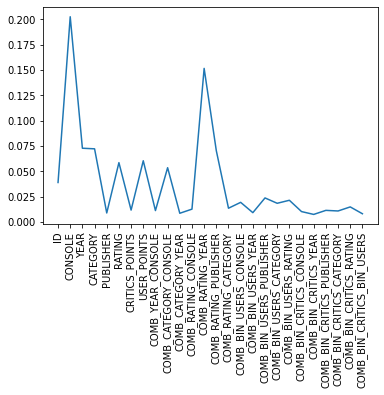

In [18]:
plt.plot(model.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90);

In [19]:
model = catboost.CatBoostRegressor()

model.fit(scaledX,y)
predictions3 = model.predict(scaledXtest)

if(VALIDATION):
    print(mean_squared_error(yvalid,predictions3,squared=False))

Learning rate set to 0.048795
0:	learn: 2.4685286	total: 58.2ms	remaining: 58.1s
1:	learn: 2.4394431	total: 70.5ms	remaining: 35.2s
2:	learn: 2.4144358	total: 77.3ms	remaining: 25.7s
3:	learn: 2.3864850	total: 83.4ms	remaining: 20.8s
4:	learn: 2.3605184	total: 91.3ms	remaining: 18.2s
5:	learn: 2.3376734	total: 97.7ms	remaining: 16.2s
6:	learn: 2.3174078	total: 104ms	remaining: 14.7s
7:	learn: 2.2977624	total: 112ms	remaining: 13.9s
8:	learn: 2.2772511	total: 130ms	remaining: 14.4s
9:	learn: 2.2513395	total: 137ms	remaining: 13.6s
10:	learn: 2.2329953	total: 142ms	remaining: 12.8s
11:	learn: 2.2155212	total: 148ms	remaining: 12.2s
12:	learn: 2.1927392	total: 152ms	remaining: 11.5s
13:	learn: 2.1709148	total: 156ms	remaining: 11s
14:	learn: 2.1457148	total: 160ms	remaining: 10.5s
15:	learn: 2.1287735	total: 164ms	remaining: 10.1s
16:	learn: 2.1108496	total: 168ms	remaining: 9.73s
17:	learn: 2.0957069	total: 173ms	remaining: 9.42s
18:	learn: 2.0794947	total: 177ms	remaining: 9.13s
19:	lea

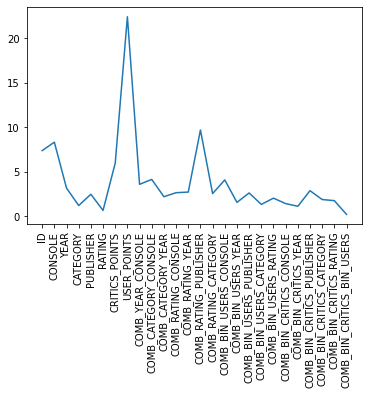

In [20]:
plt.plot(model.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90);

## Linear Model

In [21]:
useless_lin_feat = ['ID'] + comb_feat

X = train.drop(['SalesInMillions'] + useless_lin_feat, axis=1) 
y = train.SalesInMillions
Xtest = test.drop(['SalesInMillions'] + useless_lin_feat, axis=1)

scaledX = preprocessing.scale(X)
scaledXtest = preprocessing.scale(Xtest)

In [22]:
model = LinearRegression()

model.fit(scaledX,y)
predictions4 = model.predict(scaledXtest)

if(VALIDATION):
    print(mean_squared_error(yvalid,predictions4,squared=False))

In [23]:
model = svm.SVR()

model.fit(scaledX,y)
predictions5 = model.predict(scaledXtest)

if(VALIDATION):
    print(mean_squared_error(yvalid,predictions5,squared=False))

In [24]:
model = KNeighborsRegressor()

model.fit(scaledX,y)
predictions6 = model.predict(scaledXtest)

if(VALIDATION):
    print(mean_squared_error(yvalid,predictions6,squared=False))

## StackNet

In [25]:
#useless_stack_feat = ['ID','BIN_USERS','BIN_CRITICS']

X = train.drop(['SalesInMillions'] + useless_tree_feat, axis=1) 
y = train.SalesInMillions
Xtest = test.drop(['SalesInMillions'] + useless_tree_feat, axis=1)

scaledX = preprocessing.scale(X)
scaledXtest = preprocessing.scale(Xtest)

In [26]:
models = [
    [   
        Ridge(alpha=0.001, normalize=True, random_state=1234),
        RandomForestRegressor(n_estimators=300,n_jobs=-1),
        ExtraTreesRegressor(n_estimators=200, max_features=0.5, max_depth=15, random_state=7),
        xgb.XGBRegressor(learning_rate=0.05,n_jobs=-1),
        catboost.CatBoostRegressor(),
        PCA(n_components=1, random_state=1)
    ],
    [
        Ridge(alpha=0.001, normalize=True, random_state=1234)
    ]
]

model = StackNetRegressor(models,metric='rmse',n_jobs=-1,folds=4)

model.fit(scaledX,y)
predictions7 = model.predict(scaledXtest)

if(VALIDATION):
    print(mean_squared_error(yvalid,predictions7,squared=False))

In [27]:
#predictions = (predictions1+predictions2+predictions3+predictions4+predictions5)/5
predictions = predictions7

if(VALIDATION):
    print(mean_squared_error(yvalid,predictions,squared=False))

In [28]:
if(VALIDATION == False):
    submission = pd.read_csv('Sample_Submission.csv')
    submission.SalesInMillions = predictions
    submission.to_csv('FinalStack.csv',index=False)
    print(submission.head())

   SalesInMillions
0         1.503543
1         2.363054
2         3.213542
3         1.833729
4         1.725391
